In [8]:
# General Imports
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import os
import kagglehub
import cv2

from tensorflow import keras
# Visualization
import matplotlib.pyplot as plt

# Building Model
from keras.utils import plot_model
from tensorflow.keras import models
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import legacy
from tensorflow.keras.optimizers import Adam

# Training Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

# Data Processing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Accuracy
from sklearn.metrics import accuracy_score

In [9]:
#Download data set and get the path
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path);

Path to dataset files: C:\Users\anama\.cache\kagglehub\datasets\masoudnickparvar\brain-tumor-mri-dataset\versions\1


In [10]:
train_dir = path + "/Training"
test_dir = path + "/Testing"
#train_dataset = train_dir.flow_from_directory(train_dir, target_size=(250,250))
#test_dataset = test_dir.flow_from_directory(test_dir, target_size=(250,250))

In [11]:
cv2.imread(path + "/Training/glioma/Tr-glTr_0000.jpg").shape

(512, 512, 3)

In [12]:
img = load_img(path + "/Training/glioma/Tr-glTr_0000.jpg")

In [13]:
#for getting class indices
datagen = ImageDataGenerator(rescale=1./255)

train_dataset = datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)
test_dataset = datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)
print(train_dataset.class_indices)
print(train_dataset.classes)
print(test_dataset.class_indices)
print(test_dataset.classes)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
[0 0 0 ... 3 3 3]
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
[0 0 0 ... 3 3 3]


In [14]:
# Augmented Data Generator (with augmentation)
augmented_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

augmented_train_dataset = augmented_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

augmented_test_dataset = augmented_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

print(augmented_train_dataset.class_indices)
print(augmented_train_dataset.classes)
print(augmented_test_dataset.class_indices)
print(augmented_test_dataset.classes)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
[0 0 0 ... 3 3 3]
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
[0 0 0 ... 3 3 3]


In [15]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [16]:
#utilizing cnn with maxpooling, and all the layers are given in a form of list, one by one we provide the layers, 
# so Conv2D(how many filters you want to keep inside this layer which is how many features to learn from, 
# (size of the filters), activation function, input_shape=(256, 256, 3-->dimension because rgb) )
model = tf.keras.models.Sequential([tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
                                    #then adding a max pooling layer
                                    tf.keras.layers.MaxPooling2D(2, 2),
                                    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
                                    tf.keras.layers.MaxPooling2D(2,2),
                                    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
                                    tf.keras.layers.MaxPooling2D(2,2),
                                    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
                                    tf.keras.layers.MaxPooling2D(2,2),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(512, activation='relu'),
                                    #4 because 4 classes
                                    #softmax because we have multiple classes and not binary
                                    tf.keras.layers.Dense(4, activation='softmax')])
model.summary()

c:\Users\anama\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,454,660 (13.18 MB)

 Trainable params: 3,454,660 (13.18 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
model.compile(loss='categorical_crossentropy', 
              optimizer = Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [18]:
model_fit = model.fit(train_dataset,
          epochs=15,
          validation_data=test_dataset,
          callbacks=[callback]) 

c:\Users\anama\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 33s 177ms/step - accuracy: 0.5640 - loss: 0.9347 - val_accuracy: 0.8185 - val_loss: 0.4533
Epoch 2/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 28s 158ms/step - accuracy: 0.8589 - loss: 0.3734 - val_accuracy: 0.8146 - val_loss: 0.4242
Epoch 3/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 30s 165ms/step - accuracy: 0.9033 - loss: 0.2631 - val_accuracy: 0.8955 - val_loss: 0.2644
Epoch 4/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 29s 161ms/step - accuracy: 0.9350 - loss: 0.1769 - val_accuracy: 0.9008 - val_loss: 0.2624
Epoch 5/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 26s 146ms/step - accuracy: 0.9542 - loss: 0.1311 - val_accuracy: 0.9504 - val_loss: 0.1583
Epoch 6/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 26s 144ms/step - accuracy: 0.9811 - loss: 0.0598 - val_accuracy: 0.9512 - val_loss: 0.1345
Epoch 7/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 27s 148ms/step - accuracy: 0.9837 - loss: 0.0503 - val_accuracy: 0.9466 - val_loss: 0.1586
Epoch 8/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 26s 145ms/step - accuracy: 0.9810 - loss: 0

In [19]:
# Train the model on the augmented dataset
augmented_model_fit = model.fit(
    augmented_train_dataset,
    epochs=15,
    validation_data=augmented_test_dataset,
    callbacks=[callback]
)

Epoch 1/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 47s 261ms/step - accuracy: 0.6112 - loss: 1.1362 - val_accuracy: 0.6484 - val_loss: 0.8563
Epoch 2/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 48s 268ms/step - accuracy: 0.7566 - loss: 0.6009 - val_accuracy: 0.7544 - val_loss: 0.6299
Epoch 3/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 48s 268ms/step - accuracy: 0.8189 - loss: 0.4749 - val_accuracy: 0.8154 - val_loss: 0.4916
Epoch 4/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 46s 257ms/step - accuracy: 0.8489 - loss: 0.3886 - val_accuracy: 0.8345 - val_loss: 0.4283
Epoch 5/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 46s 255ms/step - accuracy: 0.8676 - loss: 0.3488 - val_accuracy: 0.8703 - val_loss: 0.3579
Epoch 6/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 46s 257ms/step - accuracy: 0.8869 - loss: 0.3047 - val_accuracy: 0.8436 - val_loss: 0.4406
Epoch 7/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 50s 279ms/step - accuracy: 0.8972 - loss: 0.2909 - val_accuracy: 0.8719 - val_loss: 0.3420
Epoch 8/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 48s 269ms/step - accuracy: 0.8994 - loss: 0

In [ ]:
# Get predictions for test dataset
y_pred_probs = model.predict(test_dataset)
y_pred = np.argmax(y_pred_probs, axis=1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step


In [22]:
misclassified_list = []
print(len(y_pred))
for i in range(len(y_pred)):
    if y_pred[i] != test_dataset.classes[i]:
        misclassified_list.append(i)

1311


975
Glioma:242
Meningiona: 235
No Tumor: 269
Pituitary: 229
Total Misclassified: 975


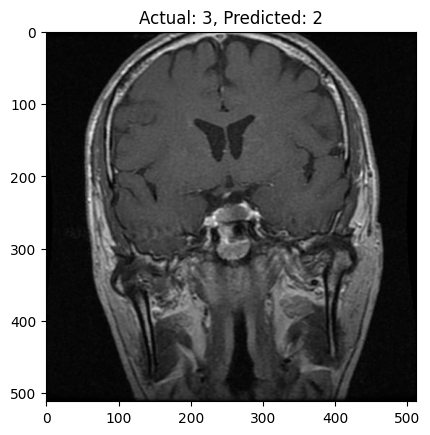

In [24]:
cout = misclassified_list.__len__()
glioma = 0 
meningiona = 0
notumor = 0
pit = 0
print(cout)
for i in misclassified_list[:993]:
    img = cv2.imread(test_dataset.filepaths[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if(test_dataset.classes[i] == 0 and y_pred[i] != 0):
        glioma += 1
    elif(test_dataset.classes[i] == 1 and y_pred[i] != 1):
        meningiona += 1
    elif(test_dataset.classes[i] == 2 and y_pred[i] != 2):
        notumor += 1
    elif(test_dataset.classes[i] == 3 and y_pred[i] != 3):
        pit += 1
    plt.imshow(img) 
    plt.title(f"Actual: {test_dataset.classes[i]}, Predicted: {y_pred[i]}")

print(f"Glioma:{glioma}")
print(f"Meningiona: {meningiona}")
print(f"No Tumor: {notumor}")
print(f"Pituitary: {pit}")
print(f"Total Misclassified: {cout}")

In [ ]:

y_true = test_dataset.classes
class_labels = list(test_dataset.class_indices.keys())

class_accuracies = {}
for class_id, class_name in enumerate(class_labels):
    class_mask = (y_true == class_id)
    class_accuracy = accuracy_score(y_true[class_mask], y_pred[class_mask])
    class_accuracies[class_name] = class_accuracy

# Print results
for class_name, accuracy in class_accuracies.items():
    print(f"Accuracy for class {class_name}: {accuracy:.2%}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step
Accuracy for class glioma: 21.33%
Accuracy for class meningioma: 22.88%
Accuracy for class notumor: 28.89%
Accuracy for class pituitary: 22.00%


In [ ]:
# Get predictions for the augmented test dataset
y_pred_probs_augmented = model.predict(augmented_test_dataset)
y_pred_augmented = np.argmax(y_pred_probs_augmented, axis=1)

y_true_augmented = augmented_test_dataset.classes
class_labels_augmented = list(augmented_test_dataset.class_indices.keys())

class_accuracies_augmented = {}
for class_id, class_name in enumerate(class_labels_augmented):
    class_mask_augmented = (y_true_augmented == class_id)
    class_accuracy_augmented = accuracy_score(y_true_augmented[class_mask_augmented], y_pred_augmented[class_mask_augmented])
    class_accuracies_augmented[class_name] = class_accuracy_augmented

for class_name, accuracy in class_accuracies_augmented.items():
    print(f"Accuracy for class {class_name} on augmented test data: {accuracy:.2%}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step
Accuracy for class glioma on augmented test data: 20.00%
Accuracy for class meningioma on augmented test data: 22.22%
Accuracy for class notumor on augmented test data: 32.84%
Accuracy for class pituitary on augmented test data: 24.33%


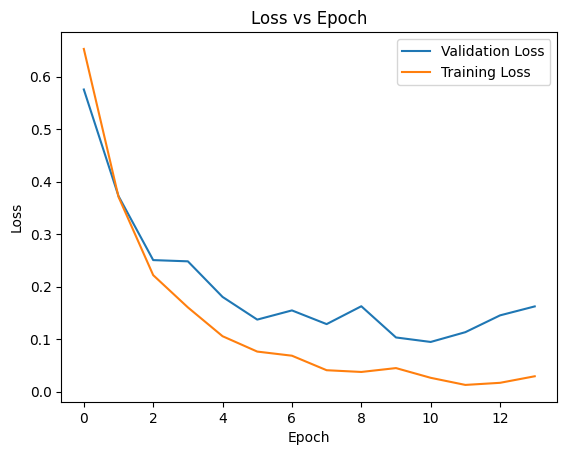

In [ ]:
plt.plot(model_fit.history['val_loss'], label='Validation Loss')
plt.plot(model_fit.history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.savefig("epoch-loss.png")
plt.show()

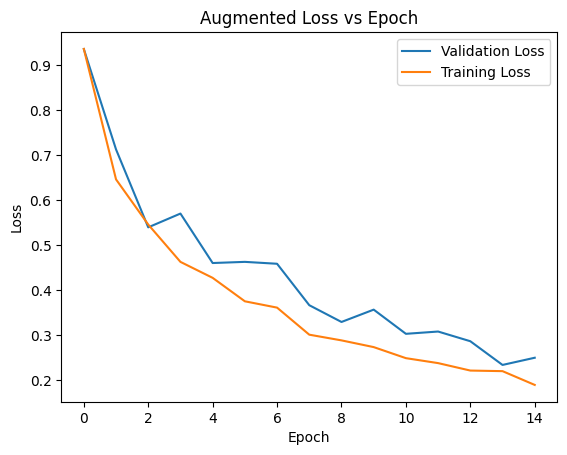

In [ ]:
plt.plot(augmented_model_fit.history['val_loss'], label='Validation Loss')
plt.plot(augmented_model_fit.history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Augmented Loss vs Epoch')
plt.legend()
plt.savefig("epoch-loss-augmented.png")
plt.show()